In [1]:
!pip install bertopic
!pip install -U FlagEmbedding
!pip install -U sentence-transformers

     |████████████████████████████████| 141 kB 3.1 MB/s eta 0:00:01


  Created wheel for FlagEmbedding: filename=FlagEmbedding-1.2.10-py3-none-any.whl size=166120 sha256=548a545a5370e732d93381bc4f1999984df8aa8528a36ad1b32af22c21a0d305
  Stored in directory: /home/paula/.cache/pip/wheels/3b/1d/d2/eec38cd59144f4c9767d7c55cfae8e8feec699071aa41ca5da
Successfully built FlagEmbedding
  Attempting uninstall: FlagEmbedding
    Found existing installation: FlagEmbedding 1.2.8
    Uninstalling FlagEmbedding-1.2.8:
      Successfully uninstalled FlagEmbedding-1.2.8
     |████████████████████████████████| 224 kB 2.9 MB/s eta 0:00:01


  Attempting uninstall: sentence-transformers
    Found existing installation: sentence-transformers 2.7.0
    Uninstalling sentence-transformers-2.7.0:
      Successfully uninstalled sentence-transformers-2.7.0


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import nltk
import re

from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer

from FlagEmbedding import BGEM3FlagModel
from bertopic import BERTopic
from umap import UMAP

/home/paula/anaconda3/envs/new/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.13) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/home/paula/anaconda3/envs/new/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/paula/anaconda3/envs/new/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See http

In [4]:
df = pd.read_csv("/home/paula/Documents/exchange/MatRac/IJS/social_services-2.0.cvs")

# Basics

In [5]:
df.columns

Index(['Unnamed: 0', 'uuid', 'created', 'country', 'published', 'media',
       'media_type', 'title', 'body'],
      dtype='object')

In [6]:
#the index column gets duplicated so remove it 

df.drop(df.columns[df.columns.str.contains(
    'Unnamed', case=False)], axis=1, inplace=True)

In [7]:
print(len(df))
df.head()

14487


,uuid,created,country,published,media,media_type,title,body
0,29fee300-f8b6-11de-9f97-02000015df5b,2010-01-03 22:20:14+00:00,SI,2010-01-03 23:00:00+00:00,Primorske novice,print,Raketa ga je v oko,PRIMORSKA ► Nesreče kljub opozorilom - Najhuje...
1,e9be6400-f98c-11de-b1b0-020000594e15,2010-01-04 23:57:28+00:00,SI,2010-01-04 23:00:00+00:00,Večer,print,Zmeda z romskim pogrebom,Organiziranje desne civilne družbe na pokopali...
2,7886ad00-f99c-11de-a26b-020000972967,2010-01-05 01:48:50+00:00,SI,2010-01-04 23:00:00+00:00,Večer,print,"Ko pozabiš, da si včeraj zažgal mleko...",Demenca pomeni v družbi nekaj negativnega in j...
3,6882d200-fa5d-11de-aeb4-020000c37e32,2010-01-06 00:49:56+00:00,SI,2010-01-05 23:00:00+00:00,Večer,print,Kam po krizi (1),"Dva dogodka sta povzročila, da smo pripravili ..."
4,07232900-fa86-11de-885f-02000090fe75,2010-01-06 05:40:42+00:00,SI,2010-01-09 23:00:00+00:00,Nedeljski dnevnik,print,Le zakaj in za kaj delati,UGODNEJE JE IMETI SOCIALNO POMOČ KOT SLUŽBO Z ...


In [8]:
df.describe()

,uuid,created,country,published,media,media_type,title,body
count,14487,14487,14487,14487,14487,14487,14487,14487
unique,14487,14486,1,4182,12,2,14220,14487
top,29fee300-f8b6-11de-9f97-02000015df5b,2013-09-28 00:13:22+00:00,SI,2016-07-05 22:00:00+00:00,Večer,print,8 dni/teden,PRIMORSKA ► Nesreče kljub opozorilom - Najhuje...
freq,1,2,14487,17,3239,14486,10,1


In [9]:
df["published"] = pd.to_datetime(df["published"])
df["created"] = pd.to_datetime(df["created"])

In [10]:
print(max(df["published"]))
print(min(df["published"]))

2023-12-29 23:00:00+00:00
2010-01-03 23:00:00+00:00


In [11]:
df.isnull().values.any()

False

In [12]:
#the created and published columns are different in every row so no need to remove either

df[df["created"] != df["published"]]

,uuid,created,country,published,media,media_type,title,body
0,29fee300-f8b6-11de-9f97-02000015df5b,2010-01-03 22:20:14+00:00,SI,2010-01-03 23:00:00+00:00,Primorske novice,print,Raketa ga je v oko,PRIMORSKA ► Nesreče kljub opozorilom - Najhuje...
1,e9be6400-f98c-11de-b1b0-020000594e15,2010-01-04 23:57:28+00:00,SI,2010-01-04 23:00:00+00:00,Večer,print,Zmeda z romskim pogrebom,Organiziranje desne civilne družbe na pokopali...
2,7886ad00-f99c-11de-a26b-020000972967,2010-01-05 01:48:50+00:00,SI,2010-01-04 23:00:00+00:00,Večer,print,"Ko pozabiš, da si včeraj zažgal mleko...",Demenca pomeni v družbi nekaj negativnega in j...
3,6882d200-fa5d-11de-aeb4-020000c37e32,2010-01-06 00:49:56+00:00,SI,2010-01-05 23:00:00+00:00,Večer,print,Kam po krizi (1),"Dva dogodka sta povzročila, da smo pripravili ..."
4,07232900-fa86-11de-885f-02000090fe75,2010-01-06 05:40:42+00:00,SI,2010-01-09 23:00:00+00:00,Nedeljski dnevnik,print,Le zakaj in za kaj delati,UGODNEJE JE IMETI SOCIALNO POMOČ KOT SLUŽBO Z ...
...,...,...,...,...,...,...,...,...
14482,204a9b28-a524-11ee-b156-8135109a7851,2023-12-28 01:55:07.423000+00:00,SI,2023-12-27 23:00:00+00:00,Slovenske novice,print,Evropska sredstva za lažje zaposlovanje,Evropska sredstva za lažje zaposlovanje LJUBLJ...
14483,62b2c858-a529-11ee-b156-8135109a7851,2023-12-28 02:32:46.319000+00:00,SI,2023-12-27 23:00:00+00:00,Dnevnik,print,Molitev in njeni učinki,Molitev in njeni učinki O učinkih molitev ne b...
14484,c8acb211-a5d2-11ee-b653-2fe3bf8a9fb0,2023-12-28 22:45:22.354000+00:00,SI,2023-12-28 23:00:00+00:00,Večer,print,Begunec očitke o posilstvu zanika,TIHOTAPLJENJE LJUDI Begunec očitke o posilstvu...
14485,132c4df6-a5dd-11ee-b1f1-5be2a319a44f,2023-12-28 23:59:02.309000+00:00,SI,2023-12-28 23:00:00+00:00,Primorske novice,print,Dobro življenje,NEGOVANJE ODNOSOV Dobro življenje Kakšnih petn...


In [14]:
df["media"].unique()

array(['Primorske novice', 'Večer', 'Nedeljski dnevnik',
       'Slovenske novice', 'Delo', 'Dnevnik', 'Nedelo', 'Mladina',
       'Delo - Sobotna priloga', 'Ona plus', 'Svet24', '24ur.com'],
      dtype=object)

In [15]:
#only one article is from the internet with all the rest being printed press

print(len(df[df["media_type"] == "internet"]))
len(df[df["media_type"] == "print"])

1


14486

# Duplicates

In [14]:
#there are no aricles that have a duplicate 

len(df[df["body"].duplicated() == True])

0

In [15]:
#drop the duplicate articles as instructed by specialist

#df.drop(df.index[df[df["body"].duplicated() == True].index.to_list()])

In [16]:
df.index

RangeIndex(start=0, stop=14487, step=1)

In [17]:
#at the same time there are many titles with duplicates

len(df[df["title"].duplicated() == True])

267

In [18]:
#how many unique title names with duplicates

len(df[df["title"].duplicated() == True]["title"].unique())

177

In [19]:
#some articles have been published at the same time but it doesn't have to be they are the same articles

len(df[df["published"].duplicated() == True])

10305

In [20]:
#no duplicates have the same values in other columns and the dataframe itself does not have row duplicates 

df[df[["country", "published", "media", "media_type", "title", "body"]].duplicated() == True]

,uuid,created,country,published,media,media_type,title,body


In [21]:
df['title'] = df['title'].map(lambda x: x.lower())
df['body'] = df['body'].map(lambda x: x.lower())

In [22]:
print(len(df[df["title"] == "pomembne številke"]))
len(df[df["title"] == "ne"])

0


0

In [23]:
tit = []
for title in df[df["title"].duplicated() == True]["title"].unique():
    tit.append(title)

In [24]:
indices = []
for i in tit:
    indices.append(df[df["title"] == i].index.to_list())

In [25]:
dup_titles = pd.DataFrame(columns=["title", "indices"])
dup_titles["title"] = tit
dup_titles["indices"] = indices

In [26]:
dup_titles.to_csv("titles_duplicate.csv")

In [27]:
len(df[df["title"].duplicated() == True]["title"].unique())

183

# Plots


In [28]:
df["year"] = [date.year for date in df["published"]]

In [29]:
counts = df.groupby(["year"])["body"].count()

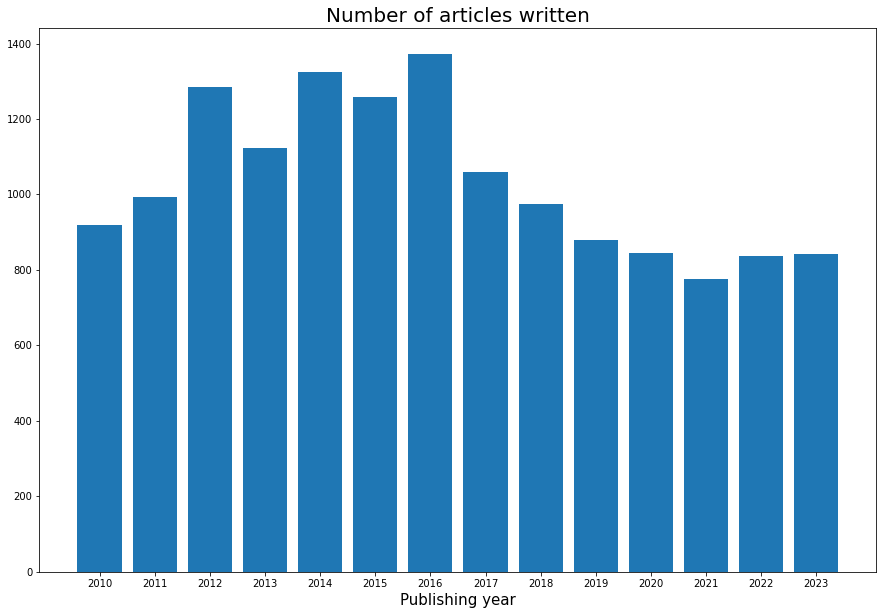

In [30]:
yrs_sorted = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022", "2023"]
plt.figure(figsize=(15, 10))
plt.bar(yrs_sorted, counts)
plt.title("Number of articles written", size=20)
plt.xlabel("Publishing year", size=15);

In [31]:
publisher_counts = df.groupby(["media"])["body"].count()

In [32]:
publisher_counts.index.to_list()

['24ur.com',
 'Delo',
 'Delo - Sobotna priloga',
 'Dnevnik',
 'Mladina',
 'Nedeljski dnevnik',
 'Nedelo',
 'Ona plus',
 'Primorske novice',
 'Slovenske novice',
 'Svet24',
 'Večer']

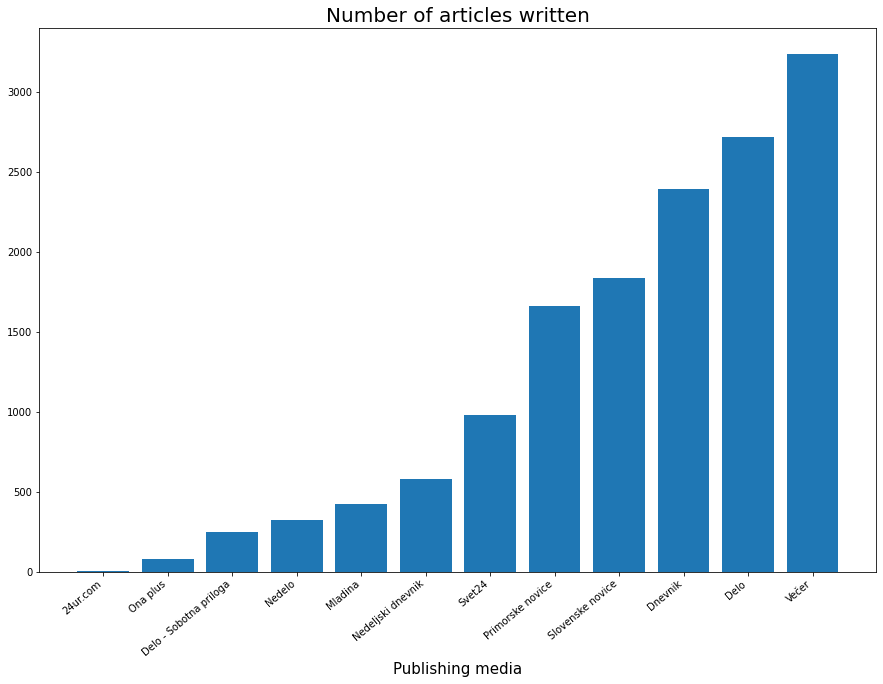

In [33]:
plt.figure(figsize=(15, 10))
plt.bar(publisher_counts.sort_values().index.to_list(), publisher_counts.sort_values())
plt.title("Number of articles written", size=20)
plt.xlabel("Publishing media", size=15)
plt.xticks(rotation=40, ha="right");

In [34]:
media = df["media"].unique()
yrs = df["year"].unique()

In [35]:
media_counts = df.groupby(["media", "year"])["body"].count()

Groupby doesn't make all the groups of equal length so we have to fix that manually for the media that does not have articles in some years.

In [36]:
ona_counts = [0, 0]
for item in df[df["media"] == "Ona plus"].groupby(["year"])["body"].count().to_list():
    ona_counts.append(item)
svet_counts = [0, 0, 0]
for item in df[df["media"] == "Svet24"].groupby(["year"])["body"].count().to_list():
    svet_counts.append(item)
tf_counts = [0, 0, 0, 0, 0, 0, 0, 0, 0]
for item in df[df["media"] == "24ur.com"].groupby(["year"])["body"].count().to_list():
    tf_counts.append(item)
for i in range(4):
    tf_counts.append(0)

In [37]:
tf_counts

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

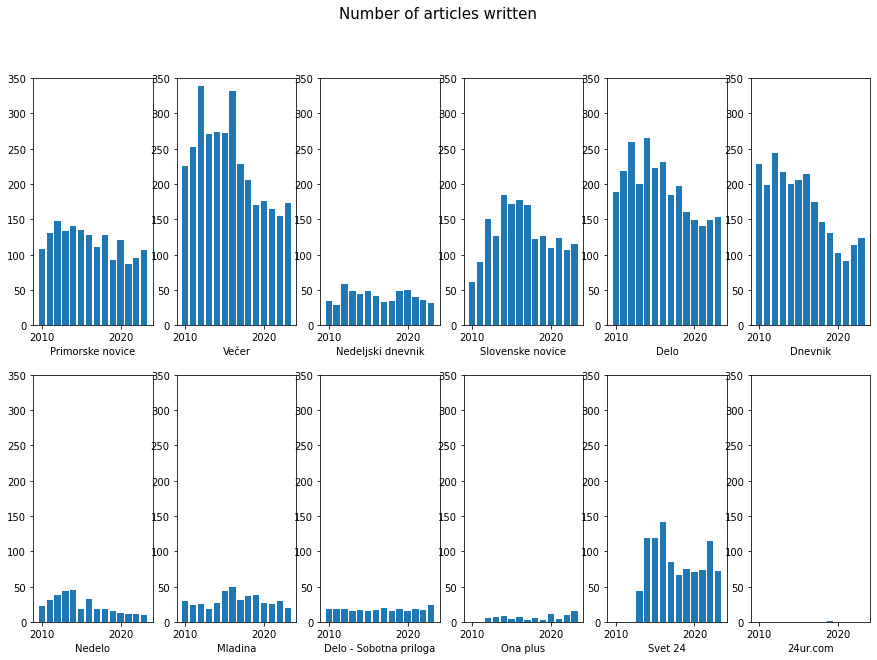

In [38]:
fig, axs = plt.subplots(2, 6, figsize=(15, 10))
for i in range(9):
    axs[i//6, i%6].bar(yrs, media_counts[media[i]])
    axs[i//6, i%6].set_ylim(bottom=0, top=350)
    axs[i//6, i%6].set_xlabel(media[i])
axs[1, 3].bar(yrs, ona_counts)
axs[1, 3].set_ylim(bottom=0, top=350)
axs[1, 3].set_xlabel("Ona plus")
axs[1, 4].bar(yrs, svet_counts)
axs[1, 4].set_ylim(bottom=0, top=350)
axs[1, 4].set_xlabel("Svet 24")
axs[1, 5].bar(yrs, tf_counts)
axs[1, 5].set_ylim(bottom=0, top=350)
axs[1, 5].set_xlabel("24ur.com")
fig.suptitle("Number of articles written", size=15);

# Titles

Let's see an example of a weird title.

In [44]:
#df[df["title"] == "ujeti v preteklost"]["body"][666]

These are all just parts of a fiction novel that have nothing to do with the news.

In [45]:
#for i in df[df["title"] == "ujeti v preteklost"]["body"]:
 #   print(i[:100])
    
#these are actually chapters of a fiction novel from Harlan Coben

Some of these titles that have duplicates signify articles which are similar but not exactly the same (due to extra characters or some small changes) so they have not been deleted before. Nevertheless, we still need to delete them because they do not provide any extra information.

Nikola said to delete articles titles "Prva stran" or "Naslovna stran" because they contain just the oeverview of what is in the news. 

In [46]:
print(len(df[df["title"].str.contains("prva stran")]["body"]))
len(df[df["title"].str.contains("naslovna stran")]["body"])

0


0

No more titles with Ne or Pomembne Številke and also no more of the previously discovered "weird" ones. It is easier to continue now. 

# Pre-processing

In [39]:
df['body'] = df['body'].map(lambda x: re.sub(r'[^\w\s]', '', x))
df['body'] = df['body'].map(lambda x: re.sub(r'[0-9]+', '', x))

In [47]:
#nltk has Slovene stopwords list

from nltk.corpus import stopwords
print(stopwords.fileids())

['arabic', 'azerbaijani', 'basque', 'bengali', 'catalan', 'chinese', 'danish', 'dutch', 'english', 'finnish', 'french', 'german', 'greek', 'hebrew', 'hinglish', 'hungarian', 'indonesian', 'italian', 'kazakh', 'nepali', 'norwegian', 'portuguese', 'romanian', 'russian', 'slovene', 'spanish', 'swedish', 'tajik', 'turkish']


In [48]:
nltk.download("stopwords")

stop_words = stopwords.words("slovene")
df['clean'] = df['body'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /home/paula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [49]:
#doing this again with the cleaned text

df["tokenized"] = [nltk.word_tokenize(df["clean"][i]) for i in range(len(df))]

In [60]:
#aux = pd.DataFrame(columns=["year", "len"])
#auxy = []
#auxl = []

#for i in range(len(df["year"].unique())):
#    yr = df["year"].unique()[i]
#    auxy.append(yr)
#    arts = [len(j) for j in df[df["year"] == yr]["tokenized"]]
#    auxl.append(sum(arts)/len(arts))
    
#aux["year"] = auxy
#aux["len"] = auxl

In [61]:
#plt.figure(figsize=(15, 10))
#plt.bar(auxy, auxl)
#plt.title("Average length of articles (expressed in tokens)", size=20)
#plt.xlabel("Publishing year", size=15);

In [52]:
df.drop(index=11020, inplace=True)
#removing the 24ur web article

In [54]:
df.to_csv("Corpus.csv")